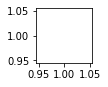

In [1]:
'''
For some reason need to plot before finishing imports or else can't plot without crashing
'''
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(1,1))
plt.plot([1],[1])

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.optim import Adam

from scipy.special import softmax

from tqdm import tqdm

import gym
from gym import error, spaces, utils



In [8]:
x = torch.tensor([-1, 4, 6])

In [9]:
Categorical(x).probs

ValueError: Expected parameter probs (Tensor of shape (3,)) of distribution Categorical(probs: torch.Size([3])) to satisfy the constraint Simplex(), but found invalid values:
tensor([-0.1111,  0.4444,  0.6667])

In [12]:
torch.nn.init.constant_(

<function torch.nn.init.constant_(tensor: torch.Tensor, val: float) -> torch.Tensor>

In [3]:
class BanditsEnv(gym.Env, utils.EzPickle):    
    def __init__(self, num_timesteps=100, num_arms=2, reward_probabilities=np.array([0.25, 0.75]),
                require_central_saccade=False, changing_reward_probabilities=False):
        '''
        Configure the multi-arm bandit environment
        
        num_trials: How many trials the environment should be run for
        num_arms: How many arms there are for the bandit
        reward_probabilities: Probability of rewarding when arm is pulled
        require_central_saccade: At each trial, we will require a central saccade before
            an arm can be pulled (agent must produced a central action)
            NOT IMPLEMENTED
        changing_reward_probabilities: If set to True, the arms may change their output
            probabilities over time. Then reward_probabilities should be a size
            (num_timesteps, num_arms) array, so at each timestep the reward probabiliies
            are given by reward_probabilities[self.timestep]
            
        observation_space: 2 with central saccade, 1 without
        action_space: num_arms + 2 for central saccade, num_arms + 1 without
            (additional action for Noop)
            Actions are
            [ARM1, ARM2,..., ARMN, CENTER]
        '''
        self.num_timesteps = num_timesteps
        self.current_trial = 0
        self.timestep = 0
        self.num_arms = num_arms
        self.reward_probabilities = reward_probabilities
        if changing_reward_probabilities:
            assert reward_probabilities.shape == (num_timesteps, num_arms), \
                f"Reward probabilities should be of shape ({num_timesteps}, {num_arms})"
        else:
            assert reward_probabilities.shape == (num_arms,), \
                f"Reward probabilities should be of shape ({num_arms},)"
        self.changing_reward_probabilities = changing_reward_probabilities
        self.require_central_saccade = require_central_saccade
        
        self.NOOP = num_arms + 2
        if require_central_saccade:
            self.observation_space = spaces.Discrete(2)
            self.action_space = spaces.Discrete(num_arms + 2)
            self.CENTER = num_arms
        else:
            self.observation_space = spaces.Discrete(1)
            self.action_space = spaces.Discrete(num_arms + 1)
        
        self.saccade_completed = False #keeps track of whether a central saccade was performed
        
    
    def step(self, action):
        '''
        Take an action, update the state
        returns: observation, reward, done, None
            observation: the state being given (0 if central saccade not required, 1 if required)
            reward: reward received at this timestep
            done: whether experiment is completed
            None: this is where info would go
        '''
        reward = self.perform_action(action)
        
        
        self.timestep += 1
        done = False
        if self.timestep >= self.num_timesteps:
            done = True

        obs = self.next_observation()
        
        return obs, reward, done, None
        
        
    def next_observation(self):
        '''
        Return the observation, which will be a 0 if an arm pull is requested and 1 if
        a central saccade is requested
        '''
        if self.require_central_saccade and not self.saccade_completed:
            return 1
        else:
            return 0
        
        
    def perform_action(self, action):
        '''
        Perform the action and determine result
        Returns the reward received
        If a saccade is required and performed, we will set self.saccade_complete to True   
        '''
        if self.require_central_saccade:
            if not self.saccade_completed:
                if action == self.CENTER:
                    self.saccade_completed = True
                    return 0
                else:
                    return -1
            else:
                if action == self.NOOP:
                    return 0
                if action == self.CENTER:
                    self.saccade_completed = False
                    return -1
                else:
                    self.saccade_completed = False
                    return self.pull_arm(action)
        
        else:
            #central saccade not required
            if action == self.NOOP:
                return 0
            else:
                return self.pull_arm(action)
    
    
    def pull_arm(self, arm):
        '''
        Pull bandit arm to check what reward is received
        '''
        #Get the reward probability of the arm being pulled
        if self.changing_reward_probabilities:
            reward_probability = self.reward_probabilities[self.timestep][arm]
        else:
            reward_probability = self.reward_probabilities[arm]
        
        if(np.random.random() < reward_probability):
            return 1
        else:
            return 0
        
    def reset(self):
        '''
        Reset state
        '''
        self.saccade_completed = False
        self.timestep = 0
        self.current_trial = 0
        
        return self.next_observation()
    
    def close(self):
        pass
    
    
    
    
def generate_bandit_env(require_central_saccade=False):
    '''
    Generate a random bandit environment with two arms of random reward probability
    '''
    arm1 = np.random.uniform()
    arm2 = 1 - arm1
    
    env = BanditsEnv(reward_probabilities=np.array([arm1, arm2]), require_central_saccade=require_central_saccade)
    return env
        

# Experiment 0: Correlated 2 bandit arms

In [11]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np

#Hyperparameters
learning_rate  = 0.0003
gamma           = 0.9
lmbda           = 0.9
eps_clip        = 0.2
K_epoch         = 4
rollout_len    = 1
buffer_size    = 30
minibatch_size = 32
action_space_size = 2
input_size = action_space_size + 2
hidden_size = 128
require_saccade = False

def format_input(previous_action=None, previous_reward=0, timestep=0, observation=False):
    '''
    If observation is False, we are not expecting an observation
    If it is an input, we are probably requiring a saccade in the environment
    '''
    inp = np.zeros(input_size)
    if(previous_action is not None):
        inp[previous_action] = 1
    inp[action_space_size] = previous_reward
    inp[action_space_size + 1] = timestep
    if observation is not False:
        inp[-1] = observation
    inp = torch.tensor(inp, dtype=torch.float).view(1, 1, -1)
    return inp

class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []
        
#         self.fc1   = nn.Linear(3,128)
#         self.fc_mu = nn.Linear(128,1)
#         self.fc_std  = nn.Linear(128,1)
#         self.fc_v = nn.Linear(128,1)
        
        self.rnn = nn.LSTM(input_size, hidden_size)
        self.fc_pi = nn.Linear(hidden_size, action_space_size)
        self.fc_v = nn.Linear(hidden_size, 1)
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.optimization_step = 0

    def pi(self, x, hidden):
#         x = F.relu(self.fc1(x))
#         mu = 2.0*torch.tanh(self.fc_mu(x))
#         std = F.softplus(self.fc_std(x))
#         return mu, std
#         x = F.relu(self.rnn())
        x, hidden = self.rnn(x, hidden)
        logits = self.fc_pi(x).squeeze()
        return Categorical(logits=logits), hidden
    
    def v(self, x, hidden):
#         x = F.relu(self.fc1(x))
#         v = self.fc_v(x)
        x, hidden = self.rnn(x, hidden)
        v = self.fc_v(x).squeeze()
        return v, hidden
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_batch, a_batch, r_batch, s_prime_batch, prob_a_batch, done_batch, hidden_batch = [], [], [], [], [], [], []
        data = []

        for j in range(buffer_size):
            for i in range(minibatch_size):
                rollout = self.data.pop()
                s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst, hidden_lst = [], [], [], [], [], [], []

                for transition in rollout:
                    s, a, r, s_prime, prob_a, done, hidden = transition
                    
                    s_lst.append(s)
                    a_lst.append([a])
                    r_lst.append([r])
                    s_prime_lst.append(s_prime)
                    prob_a_lst.append([prob_a])
                    done_mask = 0 if done else 1
                    done_lst.append([done_mask])
                    hidden_lst.append([hidden])

                s_batch.append(s_lst)
                a_batch.append(a_lst)
                r_batch.append(r_lst)
                s_prime_batch.append(s_prime_lst)
                prob_a_batch.append(prob_a_lst)
                done_batch.append(done_lst)
                hidden_batch.append(hidden_lst)
                    
            mini_batch = torch.tensor(s_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \
                          torch.tensor(r_batch, dtype=torch.float), torch.tensor(s_prime_batch, dtype=torch.float), \
                          torch.tensor(done_batch, dtype=torch.float), torch.tensor(prob_a_batch, dtype=torch.float), \
                          torch.tensor(hidden_batch, dtype=torch.float)
            data.append(mini_batch)

        return data

    def calc_advantage(self, data):
        data_with_adv = []
        init_hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
        for mini_batch in data:
            s, a, r, s_prime, done_mask, old_log_prob, hidden_prime = mini_batch
            
            with torch.no_grad():
                v_prime, _ = self.v(s_prime, hidden_prime)
                v, _ = self.v(s, init_hidden)
                td_target = r + gamma * v_prime * done_mask
                delta = td_target - v
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float).view(-1)
            data_with_adv.append((s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage))

        return data_with_adv

        
    def train_net(self, data):
        init_hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
        pg_losses = []
        v_losses = []
        for i in range(K_epoch):
            for mini_batch in data:
                s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage = mini_batch
                v, _ = self.v(s, init_hidden)
                dist, _ = self.pi(s, init_hidden)
                log_prob = dist.log_prob(a)
                ratio = torch.exp(log_prob - old_log_prob)  # a/b == exp(log(a)-log(b))

                surr1 = ratio * advantage
                surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
                
                pg_loss = -torch.min(surr1, surr2).mean()
                v_loss = F.smooth_l1_loss(v, td_target)
                
                loss = pg_loss + v_loss

                self.optimizer.zero_grad()
                loss.mean().backward()
                nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                self.optimizer.step()
                self.optimization_step += 1
                
                pg_losses.append(pg_loss)
                v_losses.append(v_loss)
        return pg_losses, v_losses
                
        
# def main():
model = PPO()
# score = 0.0
print_interval = 20
# rollout = []

def run_episode(env):
    '''
    Run an episode with the given environment
    return (s, a, r, s', done, log_prob, second_hidden) from episode
    '''
#     env = generate_bandit_env()
    s = env.reset()
#     print(env.reward_probabilities)
    score = 0
    a = None
    r = 0
    t = 0
    hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
    done = False
    
    ep_s = []
    ep_s_prime = []
    ep_r = []
    ep_a = []
    ep_done = []
    ep_hidden = []
    ep_log_prob = []

    while not done:
        s = format_input(a, r, t)
#             mu, std = model.pi(torch.from_numpy(s).float())
        dist, hidden = model.pi(s, hidden)
        a = dist.sample()
        log_prob = dist.log_prob(a)
        s_prime, r, done, info = env.step(a.item())
        t = t + 1
        r = r

        s_prime = format_input(a, r, t)
#             rollout.append((s, a, r, s_prime, log_prob.item(), done, (hidden[0].detach(), hidden[1].detach())))

        ep_s.append(s.squeeze())
        ep_s_prime.append(s_prime.squeeze())
        ep_a.append(a)
        ep_r.append(r)
        ep_done.append(done)
        ep_hidden.append(hidden)
        ep_log_prob.append(log_prob)

        s = s_prime
        score += r
        if done:
            batch_s = torch.stack(ep_s).view(-1, 1, input_size)
            batch_s_prime = torch.stack(ep_s_prime).view(-1, 1, input_size)
            batch_r = torch.tensor(ep_r)
            batch_a = torch.tensor(ep_a)
            ep_done_mask = [0 if done else 1 for done in ep_done]
            batch_done = torch.tensor(ep_done_mask)
            batch_log_prob = torch.tensor(ep_log_prob)
            batch_hidden_prime = ep_hidden[1]
            data = (batch_s, batch_a, batch_r, batch_s_prime, batch_done, batch_log_prob, batch_hidden_prime)
#             batch.append(data)
            return data, score

batch = []
score = 0
reward_probability_options = [np.array([0.25, 0.75]), np.array([0.75, 0.25])]
for n_epi in range(300):
#     env = generate_bandit_env()
#     env = BanditsEnv(num_timesteps=10, reward_probabilities=np.array([0.75, 0.25]))
    reward_probability = reward_probability_options[np.random.choice([0, 1])]
    env = BanditsEnv(num_timesteps=100, reward_probabilities=reward_probability)
    data, ep_score = run_episode(env)
    batch.append(data)
    score += ep_score
        
    if n_epi%5 == 4:
        batch = model.calc_advantage(batch)
        model.train_net(batch)
        batch = []
    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {:.1f}, opt step: {}".format(n_epi, score/print_interval, model.optimization_step))
        score = 0.0

env.close()

# if __name__ == '__main__':
#     main()

RuntimeError: Expected object of type torch.FloatTensor but found type torch.LongTensor for argument #2 'other'

In [21]:
v_prime

NameError: name 'v_prime' is not defined

In [12]:
env.reset()

0

In [15]:
obs, reward, done, info = env.step(0)

In [16]:
action = 0

In [13]:
format_input()

tensor([[[0., 0., 0., 0.]]])

In [18]:
format_input(action, reward, 1)

tensor([[[1., 0., 0., 1.]]])

In [10]:
# reward_probability = reward_probability_options[np.random.choice([0, 1])]
reward_probability = np.array([0.25, 0.75])
env = BanditsEnv(num_timesteps=20, reward_probabilities=reward_probability)
data, score = run_episode(env)
print(score)
batch = [data]
batch_adv = model.calc_advantage(batch)

8


In [11]:
batch_adv

[(tensor([[[ 0.,  0.,  0.,  0.]],
  
          [[ 0.,  1.,  0.,  1.]],
  
          [[ 1.,  0.,  0.,  2.]],
  
          [[ 0.,  1.,  1.,  3.]],
  
          [[ 1.,  0.,  0.,  4.]],
  
          [[ 1.,  0.,  1.,  5.]],
  
          [[ 0.,  1.,  1.,  6.]],
  
          [[ 0.,  1.,  1.,  7.]],
  
          [[ 1.,  0.,  0.,  8.]],
  
          [[ 1.,  0.,  0.,  9.]],
  
          [[ 1.,  0.,  0., 10.]],
  
          [[ 1.,  0.,  0., 11.]],
  
          [[ 1.,  0.,  0., 12.]],
  
          [[ 1.,  0.,  0., 13.]],
  
          [[ 1.,  0.,  1., 14.]],
  
          [[ 1.,  0.,  0., 15.]],
  
          [[ 1.,  0.,  0., 16.]],
  
          [[ 0.,  1.,  1., 17.]],
  
          [[ 1.,  0.,  1., 18.]],
  
          [[ 1.,  0.,  0., 19.]]]),
  tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
  tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1]),
  tensor([[[ 0.,  1.,  0.,  1.]],
  
          [[ 1.,  0.,  0.,  2.]],
  
          [[ 0.,  1.,  1.,  3.]],
  
      

In [9]:
results = model.train_net(batch_adv)

In [ ]:
for i in range(20):
    

In [127]:
results

([tensor([2.9879, 3.1356, 2.6249, 2.2081, 1.7936, 1.4282, 1.1225, 0.8632, 0.6328,
          0.4185], grad_fn=<NegBackward>),
  tensor([2.9869, 3.1344, 2.6231, 2.2057, 1.7912, 1.4261, 1.1209, 0.8620, 0.6320,
          0.4180], grad_fn=<NegBackward>),
  tensor([2.9852, 3.1319, 2.6200, 2.2019, 1.7874, 1.4227, 1.1182, 0.8600, 0.6305,
          0.4171], grad_fn=<NegBackward>),
  tensor([2.9829, 3.1282, 2.6155, 2.1968, 1.7823, 1.4183, 1.1145, 0.8572, 0.6285,
          0.4158], grad_fn=<NegBackward>)],
 [tensor(0.1864, grad_fn=<SmoothL1LossBackward>),
  tensor(0.1810, grad_fn=<SmoothL1LossBackward>),
  tensor(0.1724, grad_fn=<SmoothL1LossBackward>),
  tensor(0.1612, grad_fn=<SmoothL1LossBackward>)])

In [137]:
init_hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
v, _ = model.v(batch_adv[0][0], init_hidden)
td_target = batch_adv[0][6]

In [139]:
F.smooth_l1_loss(v, td_target)

tensor(0.1482, grad_fn=<SmoothL1LossBackward>)

In [140]:
v - td_target

tensor([0.4408, 0.9673, 0.7576, 0.6540, 0.5311, 0.4207, 0.3372, 0.2762, 0.2289,
        0.3611], grad_fn=<SubBackward0>)

6
18


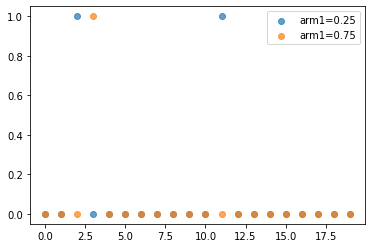

In [12]:
test_setups = [np.array([0.25, 0.75]), np.array([0.75, 0.25])]
test_results = []

with torch.no_grad():
    for rew_prob in test_setups:
        env = BanditsEnv(reward_probabilities=rew_prob, num_timesteps=20)
        data, score = run_episode(env)
        test_results.append(data[1])
        print(score)               


for i, res in enumerate(test_results):
    plt.scatter(np.arange(0, len(res)), res, label=f'arm1={test_setups[i][0]}', alpha=0.7)
    
plt.legend()

In [20]:
np.random.choice([0, 1])

1

0.35000000000000014
0.7600000000000005


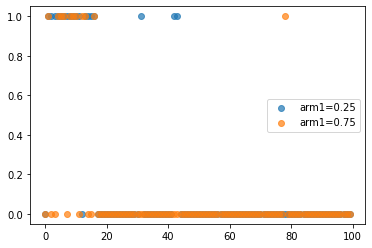

In [13]:
test_setups = [np.array([0.25, 0.75]), np.array([0.75, 0.25])]
test_results = []

with torch.no_grad():
    for rew_prob in test_setups:
        env = BanditsEnv(reward_probabilities=rew_prob)
        data, score = run_episode(env)
        test_results.append(data[1])
        print(score)               


for i, res in enumerate(test_results):
    plt.scatter(np.arange(0, len(res)), res, label=f'arm1={test_setups[i][0]}', alpha=0.7)
    
plt.legend()

In [18]:
torch.save({
    'episode': 2000,
    'optimization_steps': 20000,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': model.optimizer.state_dict()
}, 'saves/metalearner_experiment0')

# Experiment 0b: Central saccade

In [ ]:
model = PPO()
checkpoint = torch.load('saves/metalearner_experiment0')



In [5]:
action_space_size = 3
input_size = action_space_size + 3 #+3 is observation, previous reward, and timestep,
require_saccade = True
model = PPO()

env = BanditsEnv(require_central_saccade=require_saccade)
# data, score = run_episode(env)


batch = []
score = 0
print_interval = 20

for n_epi in range(2000):
    env = generate_bandit_env(require_central_saccade=True)
    data, ep_score = run_episode(env)
    batch.append(data)
    score += ep_score
        
    if n_epi%5 == 4:
        batch = model.calc_advantage(batch)
        model.train_net(batch)
        batch = []
    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {:.1f}, opt step: {}".format(n_epi, score/print_interval, model.optimization_step))
        score = 0.0

env.close()

RuntimeError: Expected object of type torch.FloatTensor but found type torch.LongTensor for argument #2 'other'

In [111]:
torch.save({
    'episode': 2000,
    'optimization_steps': 20000,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': model.optimizer.state_dict()
}, 'saves/metalearner_experiment0b')

17
34


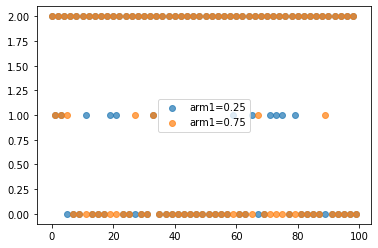

In [121]:
test_setups = [np.array([0.25, 0.75]), np.array([0.75, 0.25])]
test_results = []

with torch.no_grad():
    for rew_prob in test_setups:
        env = BanditsEnv(reward_probabilities=rew_prob, require_central_saccade=True)
        data, score = run_episode(env)
        test_results.append(data[1])
        print(score)               


for i, res in enumerate(test_results):
    plt.scatter(np.arange(0, len(res)), res, label=f'arm1={test_setups[i][0]}', alpha=0.7)
    
plt.legend()